## __Florence2を試す__

__Florence2とは__

- Microsoftが開発したVLMで、Vision系の様々なタスクを統一的に実行できるのが特徴

- 参考

  - [公式Notebook](https://huggingface.co/microsoft/Florence-2-large/blob/main/sample_inference.ipynb)

  - [npakaさんの記事](https://note.com/npaka/n/n5863c3bd2990)

- HuggingFaceのリンク: https://huggingface.co/collections/microsoft/florence-6669f44df0d87d9c3bfb76de

### __準備__

In [1]:
!nvidia-smi

Mon Dec 30 08:11:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%%capture
!pip install flash_attn timm

In [3]:
import requests
from PIL import Image, ImageDraw
import torch
from transformers import AutoProcessor, AutoModelForCausalLM

In [4]:
model_name = "microsoft/Florence-2-large"

# モデル
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, trust_remote_code=True).to("cuda:0")

# 処理器
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
# 様々なタスクを統一的に実行するための推論用関数
def inference(image, task_prompt, text_input=""):
    prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to("cuda:0", torch.float16)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    result = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return result

# バウンディングボックス描画関数
def draw_bounding_boxes(image, bboxes, labels):
    image = image.copy()
    draw = ImageDraw.Draw(image)
    for bbox, label in zip(bboxes, labels):
        draw.rectangle(bbox, outline="red", width=3)
        draw.text((bbox[0], bbox[1] - 10), label, fill="red")
    return image

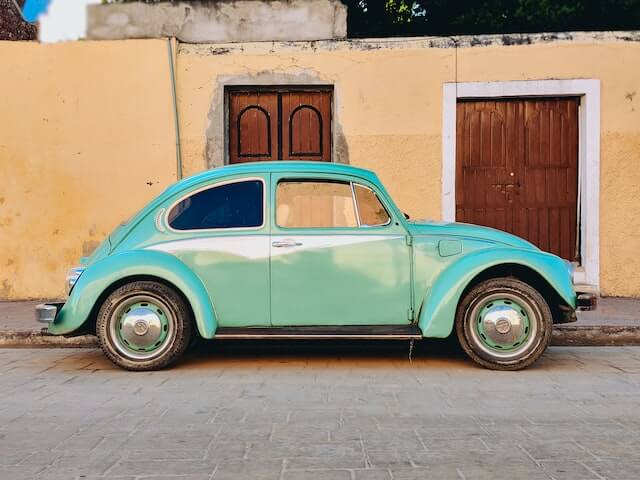

In [6]:
# サンプル画像のダウンロード
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)
image

### __実行__

`task_prompt` にタスクの種類を指定して実行する。

指定できるタスクは以下の通り

- CAPTION

  キャプション生成

- DETAILED_CAPTION

  詳細なキャプション生成

- MORE_DETAILED_CAPTION

  より詳細なキャプション生成

- OD: object detection

  物体検出

- DENSE_REGION_CAPTION

- REGION_PROPOSAL

  領域提案

- CAPTION_TO_PHRASE_GROUNDING

- REFERRING_EXPRESSION_SEGMENTATION

- REGION_TO_SEGMENTATION

- OPEN_VOCABULARY_DETECTION

- REGION_TO_CATEGORY

- REGION_TO_DESCRIPTION

- OCR

- OCR_WITH_REGION



In [7]:
# キャプション生成
task_prompt = "<CAPTION>"
inference(image, task_prompt)

{'<CAPTION>': 'a green car parked in front of a yellow building'}

In [8]:
# 詳細なキャプション生成
task_prompt = "<DETAILED_CAPTION>"
inference(image, task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a green Volkswagen Beetle parked in front of a yellow building with two brown doors, surrounded by trees and a clear blue sky.'}

In [9]:
# より詳細なキャプション生成
task_prompt = "<MORE_DETAILED_CAPTION>"
inference(image, task_prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a vintage Volkswagen Beetle car parked on a cobblestone street in front of a yellow building with two wooden doors. The car is painted in a bright turquoise color and has a white stripe running along the side. The doors are made of wood and have a rustic, weathered look. The building behind the car has a small window and a door handle. The sky is blue and there are trees in the background. The overall atmosphere of the image is peaceful and serene.'}

In [10]:
# 物体検出
task_prompt = "<OD>"
result = inference(image, task_prompt)
result

{'<OD>': {'bboxes': [[33.599998474121094,
    160.55999755859375,
    596.7999877929688,
    371.7599792480469],
   [271.67999267578125,
    242.1599884033203,
    302.3999938964844,
    246.95999145507812]],
  'labels': ['car', 'door handle']}}

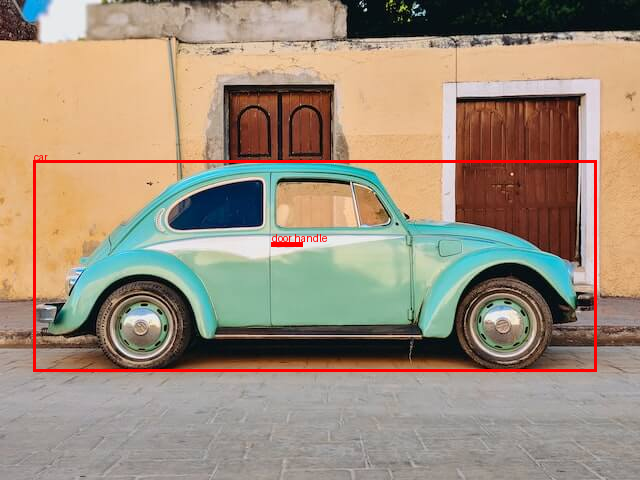

In [11]:
# 物体検出の結果の表示
draw_bounding_boxes(image, result['<OD>']['bboxes'], result['<OD>']['labels'])

In [12]:
# 高密度領域キャプション
task_prompt = "<DENSE_REGION_CAPTION>"
result = inference(image, task_prompt)
result

{'<DENSE_REGION_CAPTION>': {'bboxes': [[33.599998474121094,
    160.55999755859375,
    596.7999877929688,
    371.7599792480469],
   [271.67999267578125,
    242.1599884033203,
    302.3999938964844,
    246.95999145507812]],
  'labels': ['turquoise Volkswagen Beetle', 'door handle']}}

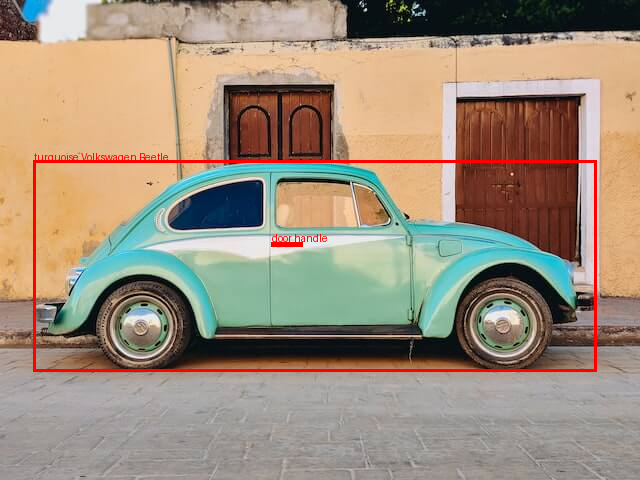

In [13]:
# 高密度領域キャプションの結果の表示
# 物体検出タスクのラベルがより詳細なテキストになるイメージ
draw_bounding_boxes(image, result['<DENSE_REGION_CAPTION>']['bboxes'], result['<DENSE_REGION_CAPTION>']['labels'])

In [14]:
# 領域提案
task_prompt = "<REGION_PROPOSAL>"
result = inference(image, task_prompt)
result

{'<REGION_PROPOSAL>': {'bboxes': [[33.599998474121094,
    160.55999755859375,
    596.7999877929688,
    371.7599792480469],
   [454.0799865722656,
    276.7200012207031,
    552.6400146484375,
    370.79998779296875],
   [95.68000030517578,
    280.55999755859375,
    198.0800018310547,
    371.2799987792969],
   [66.23999786376953,
    266.6399841308594,
    86.72000122070312,
    295.91998291015625],
   [271.67999267578125,
    242.1599884033203,
    302.3999938964844,
    246.95999145507812],
   [491.1999816894531,
    183.59999084472656,
    519.3599853515625,
    187.44000244140625],
   [408.0, 308.3999938964844, 413.7599792480469, 320.8800048828125],
   [402.8800048828125,
    212.39999389648438,
    409.91998291015625,
    219.59999084472656],
   [509.1199951171875,
    172.0800018310547,
    514.8800048828125,
    176.39999389648438]],
  'labels': ['', '', '', '', '', '', '', '', '']}}

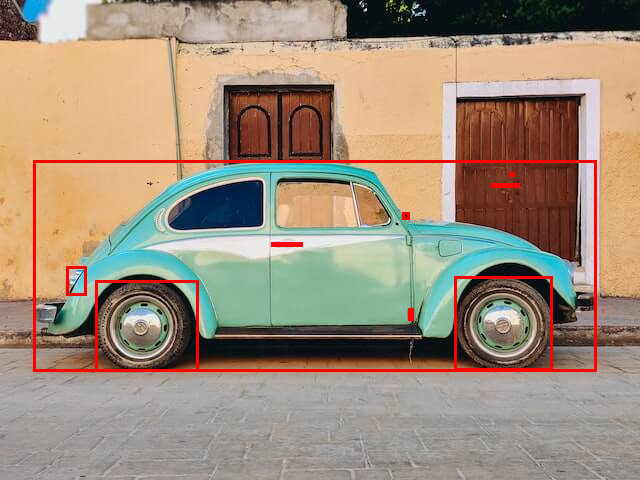

In [15]:
# 領域提案の結果の表示
# labelは何もないが、どこに領域があるのかを提示・提案するタスク
draw_bounding_boxes(image, result['<REGION_PROPOSAL>']['bboxes'], result['<REGION_PROPOSAL>']['labels'])

In [16]:
# キャプション内フレーズの画像との紐付け
task_prompt = "<CAPTION_TO_PHRASE_GROUNDING>"
text_input = "A green car parked in front of a yellow building."
result = inference(image, task_prompt, text_input)
result

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[34.880001068115234,
    159.1199951171875,
    582.0800170898438,
    374.6399841308594],
   [1.5999999046325684,
    4.559999942779541,
    639.0399780273438,
    304.55999755859375]],
  'labels': ['A green car', 'a yellow building']}}

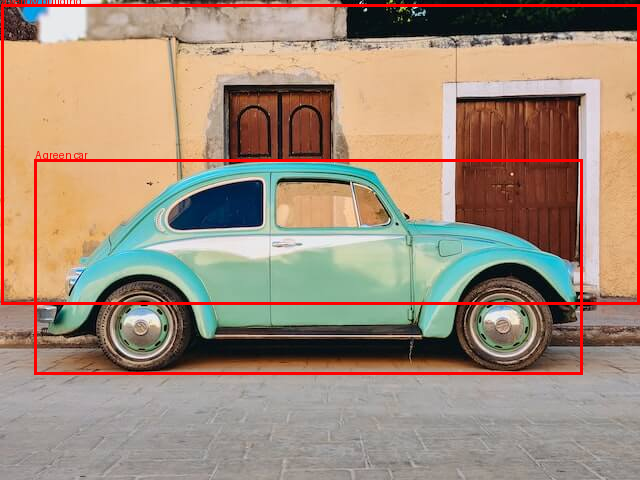

In [17]:
# キャプション内フレーズの画像との紐付けの結果の表示
# text_promptとして与えたキャプション内のフレーズが、画像中にどこで表示されているのかをbboxで表している
draw_bounding_boxes(image, result['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes'], result['<CAPTION_TO_PHRASE_GROUNDING>']['labels'])